In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn import tree
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier

In [2]:
df_train = pd.read_csv("../data/transformed_train.csv")
df_test = pd.read_csv("../data/transformed_test.csv")

# Separate our features (X) and target (y)
df_X = df_train.drop(["Status"], axis=1)
df_y = df_train[["Status"]]

# Splitting our training data into a train set and a validation set
train_X, val_X, train_y, val_y = train_test_split(
    df_X, df_y,
    shuffle=True,
    random_state=0,  # Ensure reproducible results
    test_size=0.2    # 80% Train - 20% Validation
)

print(f"train_X shape: {train_X.shape}")
print(f"train_y shape: {train_y.shape}")
print(f"val_X shape: {val_X.shape}")
print(f"val_y shape: {val_y.shape}")

train_X shape: (267700, 20)
train_y shape: (267700, 1)
val_X shape: (66926, 20)
val_y shape: (66926, 1)


In [3]:
params = {
    "n_estimators": np.arange(5, 25, 5),
    "max_depth": np.arange(2, 24, 2),
}

clf = RandomForestClassifier(
    criterion="gini",  
    class_weight="balanced",
    random_state=0   
)

trees_clf = GridSearchCV(
    clf,
    params,
    scoring=["f1", "roc_auc"], refit="f1",
    return_train_score=True,
    n_jobs=-2
)
trees_clf.fit(train_X, train_y.values.ravel())

GridSearchCV(estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=0),
             n_jobs=-2,
             param_grid={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 22]),
                         'n_estimators': array([ 5, 10, 15, 20])},
             refit='f1', return_train_score=True, scoring=['f1', 'roc_auc'])

In [4]:
trees_clf.best_params_

{'max_depth': 22, 'n_estimators': 20}

In [5]:
train_pred_y = trees_clf.predict(train_X)
val_pred_y = trees_clf.predict(val_X)

final_train_performance_report = classification_report(train_y, train_pred_y)
final_val_performance_report = classification_report(val_y, val_pred_y)

print(f"'TRAINING PERFORMANCE'\n{final_train_performance_report}")
print(f"'VALIDATION PERFORMANCE'\n{final_val_performance_report}")

'TRAINING PERFORMANCE'
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133766
           1       1.00      1.00      1.00    133934

    accuracy                           1.00    267700
   macro avg       1.00      1.00      1.00    267700
weighted avg       1.00      1.00      1.00    267700

'VALIDATION PERFORMANCE'
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     33547
           1       0.98      1.00      0.99     33379

    accuracy                           0.99     66926
   macro avg       0.99      0.99      0.99     66926
weighted avg       0.99      0.99      0.99     66926



In [6]:
column_names = df_X.columns
feature_importances = pd.DataFrame(trees_clf.best_estimator_.feature_importances_, index = column_names, columns=['importance'])
feature_importances.sort_values(by='importance', ascending=False, inplace=True)
feature_importances

,importance
ExtraMedTest,0.410826
ExtraAlcoholTest,0.358634
BMI,0.039904
GenHlth,0.036805
Age,0.031827
HighBP,0.029135
Income,0.021218
Education,0.015203
PhysHlth,0.014392
HighChol,0.012899


[Text(0.4753509493542195, 0.9782608695652174, 'ExtraMedTest <= 0.521\ngini = 0.5\nsamples = 169256\nvalue = [134228.237, 133472.237]\nclass = HighBP'),
 Text(0.2695174735617334, 0.9347826086956522, 'ExtraMedTest <= 0.518\ngini = 0.244\nsamples = 74195\nvalue = [100733.217, 16690.526]\nclass = HighBP'),
 Text(0.1700203159535083, 0.8913043478260869, 'HighBP <= 0.5\ngini = 0.314\nsamples = 52108\nvalue = [66389.664, 16118.884]\nclass = HighBP'),
 Text(0.0977795050609341, 0.8478260869565217, 'Age <= 0.708\ngini = 0.211\nsamples = 29389\nvalue = [41065.772, 5592.49]\nclass = HighBP'),
 Text(0.0598025789322895, 0.8043478260869565, 'HighChol <= 0.5\ngini = 0.19\nsamples = 22427\nvalue = [31860.995, 3799.615]\nclass = HighBP'),
 Text(0.0322482450511017, 0.7608695652173914, 'Income <= 0.786\ngini = 0.168\nsamples = 16605\nvalue = [23875.984, 2430.475]\nclass = HighBP'),
 Text(0.01448301514917298, 0.717391304347826, 'ExtraAlcoholTest <= 0.782\ngini = 0.197\nsamples = 6036\nvalue = [8524.35, 1061

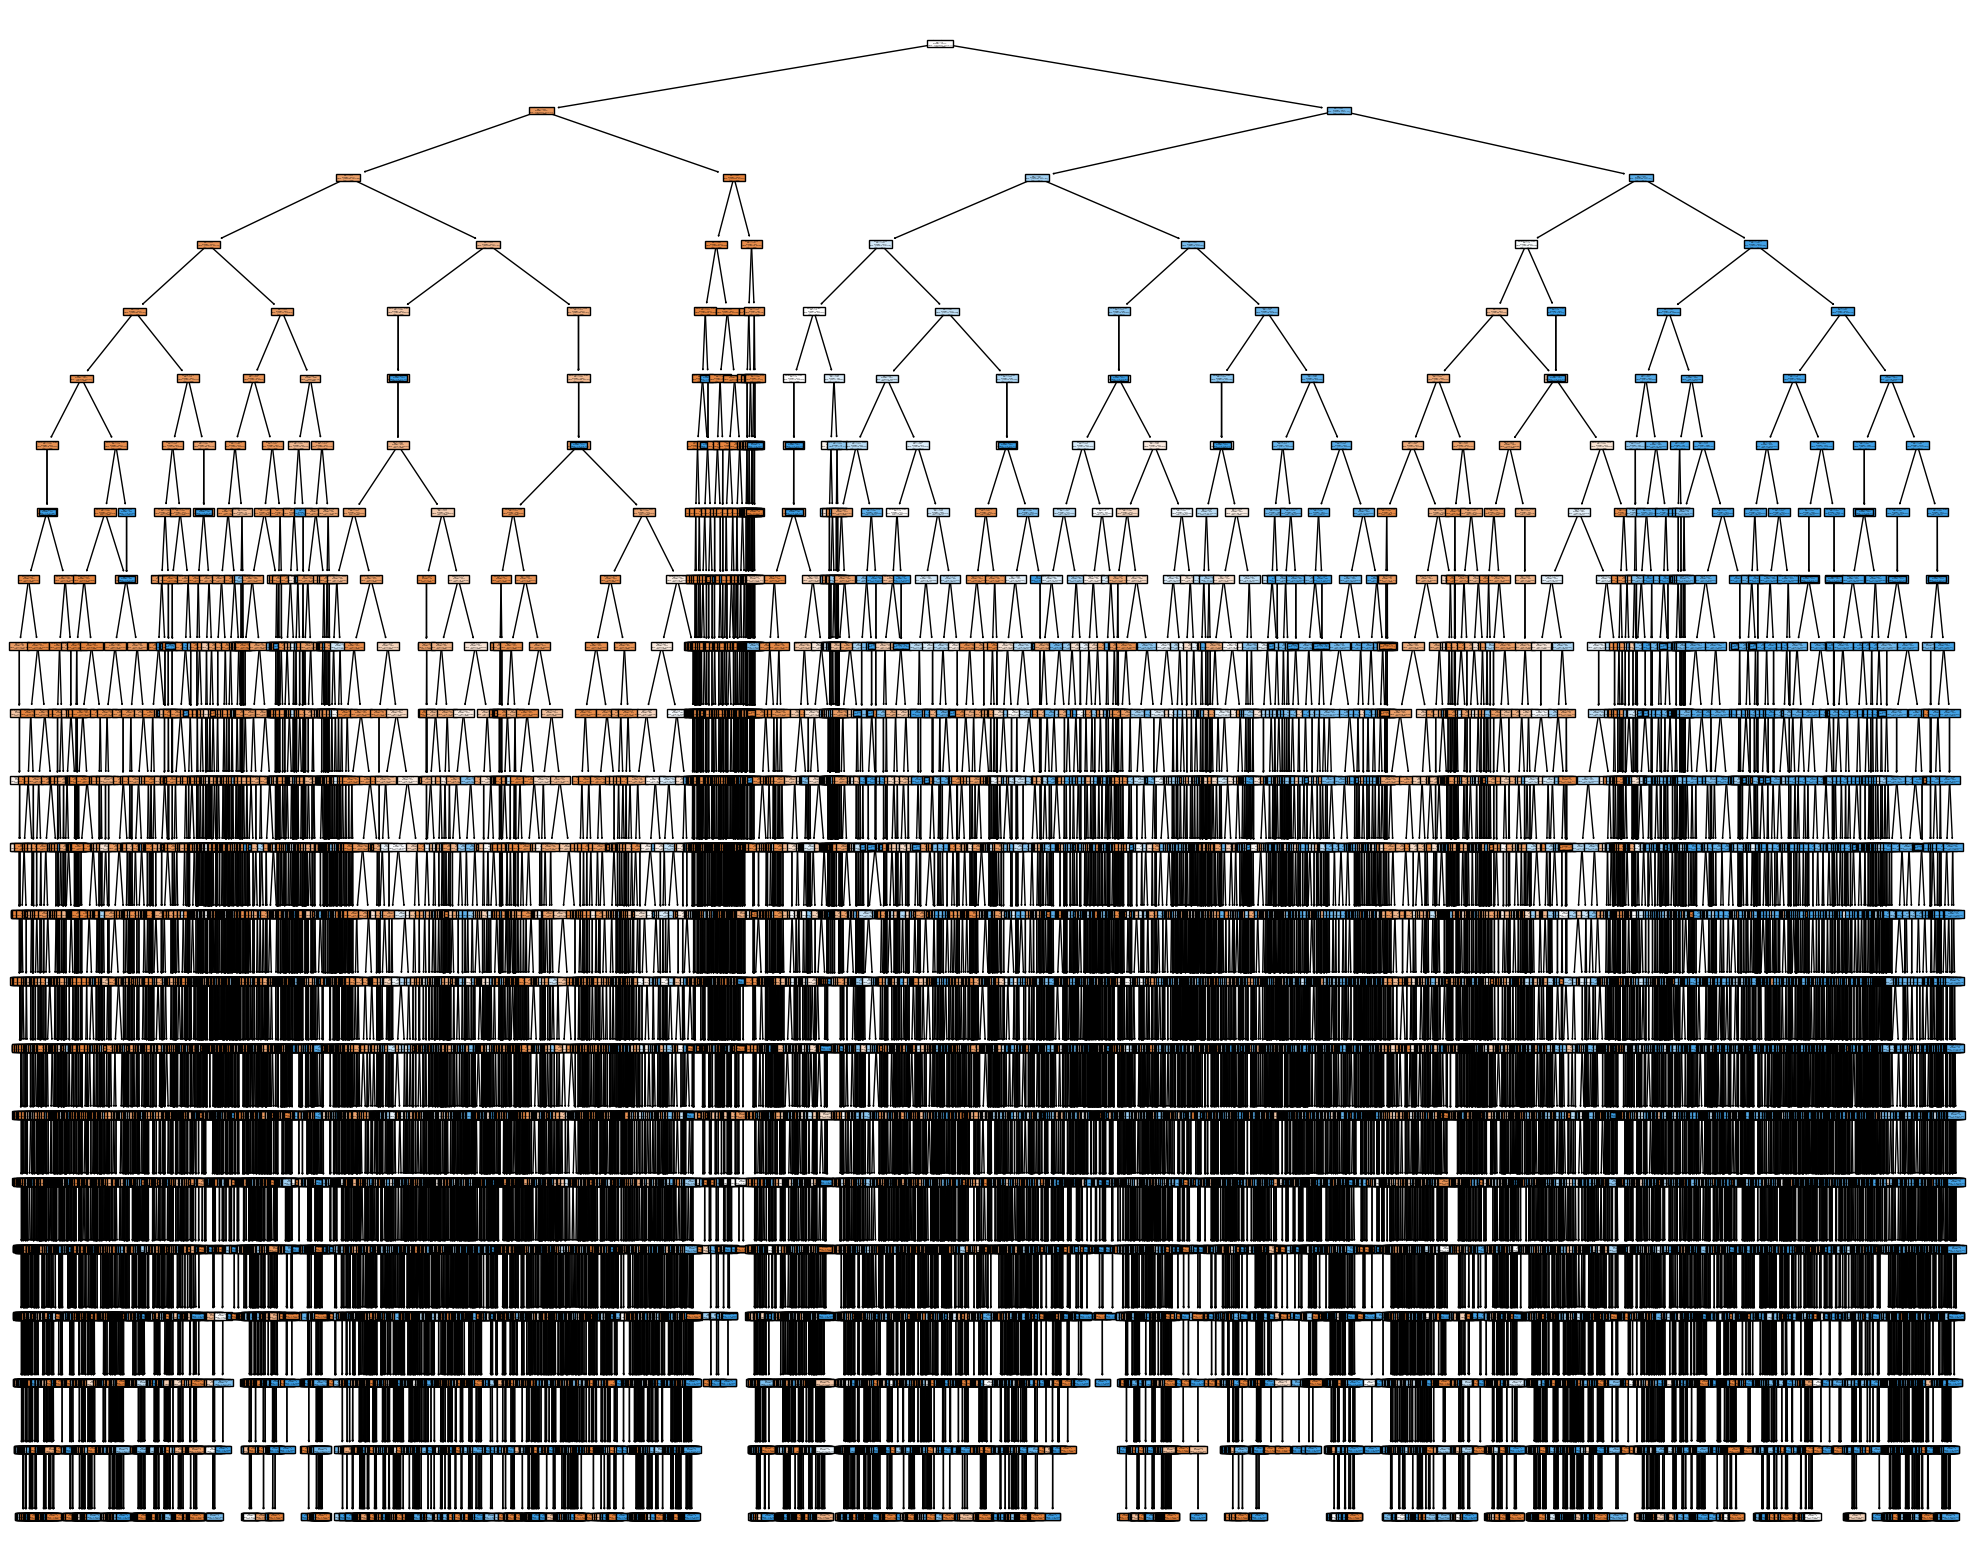

In [7]:
fig, ax = plt.subplots(figsize=(25,20))
decision_tree = trees_clf.best_estimator_.estimators_[0]
tree.plot_tree(
    decision_tree,
    feature_names=['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest'],
    class_names=['HighBP', 'HighChol', 'BMI', 'Smoker', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'GenHlth', 'MentHlth', 'PhysHlth', 'Sex', 'Age', 'Education', 'Income', 'ExtraMedTest', 'ExtraAlcoholTest'],
    filled=True, ax=ax
)

In [8]:
export_path = "../data/out/s3925921_predictions.csv"

df_test_original = pd.read_csv("../data/data_test.csv")
patient_id = df_test_original["Id"].values

pred_y = trees_clf.predict(df_test)

df_export = pd.DataFrame({"Id": patient_id, "Status": pred_y})

In [9]:
df_export.head()

,Id,Status
0,202944,0
1,202945,0
2,202946,0
3,202947,0
4,202948,0


In [10]:
df_export.to_csv(export_path, index=False)

In [11]:
accuracy = accuracy_score(val_y, val_pred_y)
precision = precision_score(val_y, val_pred_y)
recall = recall_score(val_y, val_pred_y)
f1 = f1_score(val_y, val_pred_y)
roc_auc = roc_auc_score(val_y, val_pred_y)

# Confusion matrix
conf_matrix = confusion_matrix(val_y, val_pred_y)

print("Evaluation Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC Score: {roc_auc:.4f}")

print("\nConfusion Matrix:")
print(conf_matrix)

Evaluation Metrics:
Accuracy: 0.9854
Precision: 0.9757
Recall: 0.9954
F1 Score: 0.9855
ROC AUC Score: 0.9854

Confusion Matrix:
[[32721   826]
 [  153 33226]]
